## Deep Learning
### Examen Agosto 2022

#### Alumna: Ariadna Garmendia

#### 2) Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [5]:
dataset = pd.read_csv('dataset_1.csv')
dataset = pd.DataFrame(dataset)
dataset.head()

,# X,Y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


In [6]:
dataset.rename(columns = {'# X':'X'}, inplace = True)
dataset.head()

,X,Y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


In [7]:
X = dataset.X.to_numpy()
y = dataset.Y.to_numpy()

X.shape, y.shape

((10000,), (10000,))

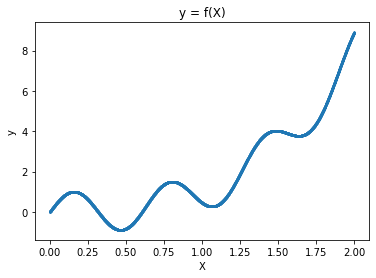

In [8]:
# Grafico función de entrada
plt.figure()
plt.scatter(X, y,1)
plt.title('y = f(X)')
plt.ylabel('y')
plt.xlabel('X')
plt.show()

Preparo los datos

In [9]:
X.shape, y.shape

((10000,), (10000,))

In [10]:
X_train = X.reshape(-1,1)
y_train = y.reshape(-1,1)


Verifico que las dimensiones quedaron bien

In [11]:
X_train.shape, y_train.shape 


((10000, 1), (10000, 1))

In [12]:
X_train[0:5, 0]

array([1.7919792 , 0.84688469, 1.00030003, 1.88418842, 0.88908891])

Código para la NNet (uso el código visto en clase)

In [13]:
class MyDataset(Dataset):

    def __init__(self, X, y): # Recibe todo el dataset
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):  # Devuelve cantidad de filas que tiene el DS
        return self.X.shape[0]

    def __getitem__(self, idx): # Esto es para poder devolver un item, muestras para iterar. Devolver una tupla con estos dos elementos
        return self.X[idx], self.y[idx]

In [14]:
train = MyDataset(X_train, y_train)


Voy a utilizar batch_size = 64

In [15]:
# El Dataloader (Clase de Pytorch) sirve para generar el batch
train_dataloader = DataLoader(train, batch_size=64, shuffle=True) # Shuffle cambia los datos del batch por cada epoch


In [16]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=100, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=50, out_features=20, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64 x 13
        x = self.linear_1(x) # x.shape -> 64 x 100 
        x = self.relu_1(x) # x.shape -> 64 x 100
        x = self.linear_2(x) # x.shape -> 64 x 50
        x = self.relu_2(x) # x.shape -> 64 x 50
        x = self.linear_3(x) # x.shape -> 64 x 50
        x = self.relu_3(x) # x.shape -> 64 x 50
        x = self.output(x) # x.shape -> 64 x 1
        return x

In [17]:
nnet = NNet()

Imprimo los detalles de la red:

In [18]:
nnet

NNet(
  (linear_1): Linear(in_features=1, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=50, out_features=20, bias=True)
  (relu_3): ReLU()
  (output): Linear(in_features=20, out_features=1, bias=True)
)

Utilizo optimizador Adam y MSE para la Loss function:

In [19]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [20]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


Entrenamiento (Nro epochs: epochs_nbr)

In [21]:
epochs_nbr = 1000

In [22]:
nnet.to(device)

loss_list = []
y_hat_list = []
#loss_valid_list = []

for epoch in range(epochs_nbr):

    running_loss = 0
    running_y_score = []
    running_y_true = []
    running_X_batch = []
   
    
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = (nnet(X_batch))
        

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy()) # Acumula predicción (para graficar lo traemos de GPU a CPU con detach)
        running_y_true += list(Y_batch.detach().cpu().numpy()) # Acumula y_true
        running_X_batch += list(X_batch.detach().cpu().numpy()) #Guardo los X para graficar(por el reshuffle no quedan en orden)
    
    # metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss} ")
    

    

Epoch 0 | Training loss: 31789.423196792603 
Epoch 1 | Training loss: 5744.593458652496 
Epoch 2 | Training loss: 4187.491683959961 
Epoch 3 | Training loss: 3990.636242389679 
Epoch 4 | Training loss: 3898.3304381370544 
Epoch 5 | Training loss: 3866.2526426315308 
Epoch 6 | Training loss: 3556.690306663513 
Epoch 7 | Training loss: 3280.632523536682 
Epoch 8 | Training loss: 3093.149772644043 
Epoch 9 | Training loss: 2996.612076282501 
Epoch 10 | Training loss: 2845.0702233314514 
Epoch 11 | Training loss: 2762.765198469162 
Epoch 12 | Training loss: 2623.3368550240993 
Epoch 13 | Training loss: 2406.490218639374 
Epoch 14 | Training loss: 2326.0581288337708 
Epoch 15 | Training loss: 2363.454043030739 
Epoch 16 | Training loss: 2341.3391761779785 
Epoch 17 | Training loss: 2381.6032586097717 
Epoch 18 | Training loss: 2291.986943244934 
Epoch 19 | Training loss: 2288.599354028702 
Epoch 20 | Training loss: 2298.529927253723 
Epoch 21 | Training loss: 2296.336713552475 
Epoch 22 | T

Preparo datos para graficar y verifico dimensiones

In [23]:
y_predicted =np.array(running_y_score).reshape(-1)
y_true =np.array(running_y_true).reshape(-1)
X_nn = np.array(running_X_batch).reshape(-1)
y_predicted.shape, y_true.shape, X_nn.shape

((10000,), (10000,), (10000,))

Plot

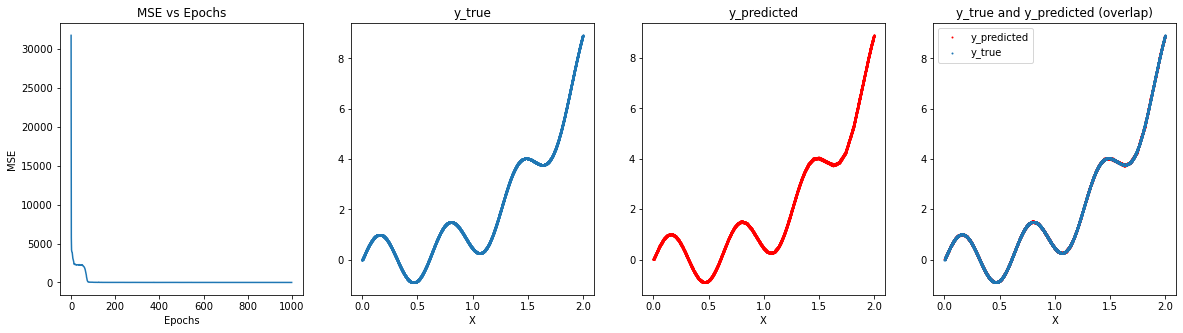

In [24]:
plt.figure(figsize=[20,5])

plt.subplot(141)
plt.plot(range(0, len(loss_list)), loss_list)
plt.title('MSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(142)
plt.scatter(X_nn,y_true,1)
plt.title('y_true')
plt.xlabel('X')

plt.subplot(143)
plt.scatter(X_nn,y_predicted,1,'r')
plt.title('y_predicted')
plt.xlabel('X')

plt.subplot(144)
plt.scatter(X_nn,y_predicted,1, 'r')
plt.scatter(X_nn,y_true,1)
plt.title('y_true and y_predicted (overlap)')
plt.xlabel('X')
plt.legend(['y_predicted', 'y_true'])

#### Conclusión: se observa en los gráficos que ahora el modelo hace overfitting - todos los puntos que la red neuronal predice, coinciden exactamente con los valores del "y" verdadero. Nota: No hice split del dataset en train y validación porque los datos de entrada corresponden a una función, con lo cual una vez que la red aprende "de memoria" esa función, la red va a predecir el valor exacto para cualquiera de esos X de entrada, aún si no los vio durante en el entrenamiento.

#### Implemento Regularización para prevenir el overfitting

1) Implemento regularización con el método Dropout (p=0.2) en las 3 capas intermedias

In [578]:
X_train.shape, y_train.shape

((10000, 1), (10000, 1))

In [579]:
X_train[0:5, 0]

array([1.7919792 , 0.84688469, 1.00030003, 1.88418842, 0.88908891])

In [580]:
train_do = MyDataset(X_train, y_train)

In [581]:
# El Dataloader (Clase de Pytorch) sirve para generar el batch
train_dataloader_do = DataLoader(train_do, batch_size=64, shuffle=True) # Shuffle cambia los datos del batch por cada epoch

In [582]:
class NNet_do(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=100, bias=True)
        self.dropout_1 = torch.nn.Dropout(p =0.1)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.dropout_2 = torch.nn.Dropout(p =0.20)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=50, out_features=20, bias=True)
        self.dropout_3 = torch.nn.Dropout(p =0.20)
        self.relu_3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=20, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64 x 1
        x = self.linear_1(x) # x.shape -> 64 x 100 
        x = self.dropout_1(x)
        x = self.relu_1(x) # x.shape -> 64 x 100
        x = self.linear_2(x) # x.shape -> 64 x 50
        x = self.dropout_2(x)
        x = self.relu_2(x) # x.shape -> 64 x 50
        x = self.linear_3(x) # x.shape -> 64 x 50
        x = self.dropout_3(x)
        x = self.relu_3(x) # x.shape -> 64 x 20
        x = self.output(x) # x.shape -> 64 x 1
        return x

Utilizo optimizador de Adam y MSE como loss function por ser un problema de Regresión

In [583]:
nnet_do = NNet_do()
optimizer = torch.optim.Adam(nnet_do.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [584]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [585]:
print(nnet_do)

NNet_do(
  (linear_1): Linear(in_features=1, out_features=100, bias=True)
  (dropout_1): Dropout(p=0.1, inplace=False)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=50, out_features=20, bias=True)
  (dropout_3): Dropout(p=0.2, inplace=False)
  (relu_3): ReLU()
  (output): Linear(in_features=20, out_features=1, bias=True)
)


In [586]:
epochs_nbr = 2500

In [587]:
  
nnet_do.to(device)

loss_list = []


for epoch in range(epochs_nbr):

    running_loss = 0
    running_y_score = []
    running_y_true = []
    running_X_batch = []


    for i, data in enumerate(train_dataloader_do):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = (nnet_do(X_batch))
        

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy()) # Acumula predicción (para graficar lo traemos de GPU a CPU con detach)
        running_y_true += list(Y_batch.detach().cpu().numpy()) # Acumula y_true
        running_X_batch += list(X_batch.detach().cpu().numpy()) #Guardo los X para graficar(por el reshuffle no quedan en orden)

    # metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch} | Training loss: {running_loss} ")
    y_predicted =np.array(running_y_score).reshape(-1)
    y_true =np.array(running_y_true).reshape(-1)
    X_nn = np.array(running_X_batch).reshape(-1)




    

Epoch 0 | Training loss: 25427.79529285431 
Epoch 1 | Training loss: 8368.007285118103 
Epoch 2 | Training loss: 7625.113576889038 
Epoch 3 | Training loss: 7275.569550514221 
Epoch 4 | Training loss: 6970.458275794983 
Epoch 5 | Training loss: 6644.4441614151 
Epoch 6 | Training loss: 6501.163149833679 
Epoch 7 | Training loss: 6216.678579330444 
Epoch 8 | Training loss: 5875.660409927368 
Epoch 9 | Training loss: 5534.466312170029 
Epoch 10 | Training loss: 5598.269118309021 
Epoch 11 | Training loss: 5595.083671092987 
Epoch 12 | Training loss: 5470.9083461761475 
Epoch 13 | Training loss: 4943.0381989479065 
Epoch 14 | Training loss: 4539.601340770721 
Epoch 15 | Training loss: 4377.605368614197 
Epoch 16 | Training loss: 4264.975513458252 
Epoch 17 | Training loss: 4028.603099346161 
Epoch 18 | Training loss: 4077.814446926117 
Epoch 19 | Training loss: 3949.420249581337 
Epoch 20 | Training loss: 3736.9271235466003 
Epoch 21 | Training loss: 3988.09981071949 
Epoch 22 | Training 

In [588]:
y_predicted =np.array(running_y_score).reshape(-1)
y_true =np.array(running_y_true).reshape(-1)
X_nn = np.array(running_X_batch).reshape(-1)
y_predicted.shape, y_true.shape, X_nn.shape

((10000,), (10000,), (10000,))

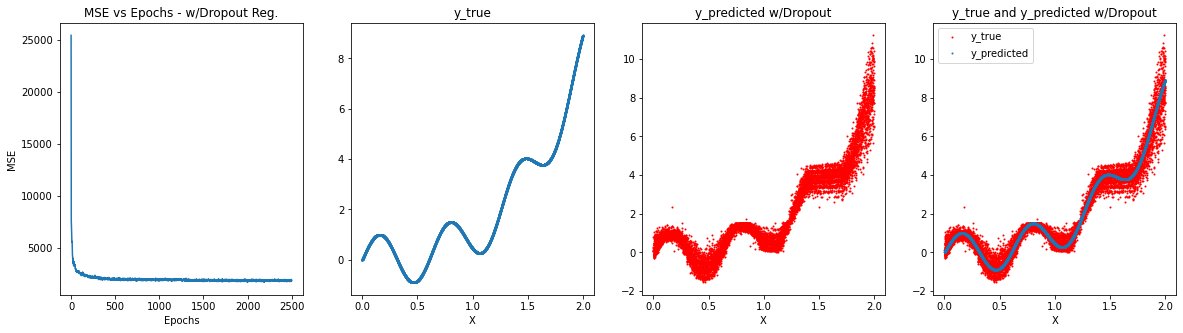

In [589]:
plt.figure(figsize=[20,5])

plt.subplot(141)
plt.plot(range(0, len(loss_list)), loss_list)
plt.title('MSE vs Epochs - w/Dropout Reg.')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(142)
plt.scatter(X_nn,y_true,1)
plt.title('y_true')
plt.xlabel('X')

plt.subplot(143)
plt.scatter(X_nn,y_predicted,1,'r')
plt.title('y_predicted w/Dropout')
plt.xlabel('X')

plt.subplot(144)
plt.scatter(X_nn,y_predicted,1, 'r')
plt.scatter(X_nn,y_true,1)
plt.title('y_true and y_predicted w/Dropout')
plt.xlabel('X')
plt.legend(['y_true', 'y_predicted'])

#### Se observa el efecto de la regulación, ahora la red ya no predice exactamente los valores de "y", sino que los y_hat ahora caen en una nube de puntos en cerca de los valores reales. Para llegar a estos resultados, utilicé el método de Dropout, y fui probando agregarlo en una y luego varias capas, analizando los resultados para distintos valores de porcentaje de droput (El que se muestra en la figura corresponde a 10% en la capa de entrada y 20% en las 2 hidden). En el archivo "Ej Nro 2 - Pruebas_Regularizacion" están los gráficos con resultados obtenidos para cada opción analizada y los parámetros utilizados en cada caso. 

#### En el caso de este dataset, como es una función, separar en training y validación no tiene mucho sentido, ya que el comportamiento del loss va a ser igual en ambos casos. Para otro tipo de dataset, el overfitting se manifestaría como buena performance en el entrenamiento, pero pobre al momento de realizar la validación porque el modelo pierde capacidad de generalizar. En esos casos lo que haría sería ajustar los parámetros del modelo con regulación de manera que se reduzca el error de validación.

#### El modelo final en el ejercicio lo elegí en base al valor del loss obtenido (ni muy chico para que el modelo no siga aprendiendo de memoria la función, ni demasiado grande para no llevarlo al otro extremo).
